In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.lgb import fit_lgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "lgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-15 16:53:11.619284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 16:53:12.080975: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 16:53:13.734962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_139


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [16:31<00:00,  3.58s/it]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,same_count_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,same_count_rolling_square_mean_100_shift_1000,reduce_step,fold
55,-88.1250,0.067688,0.067688,-13.195312,0.028885,0.000187,0.031830,627.5,0.0,47427.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,665,3
56,-88.1250,0.062500,0.062500,-13.039062,0.028732,0.000293,0.025177,687.5,0.0,47487.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,677,3
57,-88.8750,0.140625,0.140625,-2.054688,0.029480,0.000575,0.077698,747.5,0.0,47547.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,689,3
58,-89.3125,0.000000,0.000000,-14.140625,0.029739,0.000210,0.109192,807.5,0.0,47607.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,701,3
59,-89.2500,0.104187,0.104187,-6.000000,0.029984,0.000322,0.098938,867.5,0.0,47667.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,713,3


(948910, 1627)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_lgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["lightgbm"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        joblib.dump(model, os.path.join(CFG["output_dir"], f'lgb_{event}_fold_{i}.pkl'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)

with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.12144	valid_0's l2: 1.25763
[200]	valid_0's rmse: 1.01057	valid_0's l2: 1.02126
[300]	valid_0's rmse: 0.982432	valid_0's l2: 0.965173
[400]	valid_0's rmse: 0.974073	valid_0's l2: 0.948819
[500]	valid_0's rmse: 0.971195	valid_0's l2: 0.943219
[600]	valid_0's rmse: 0.969985	valid_0's l2: 0.940871
[700]	valid_0's rmse: 0.969231	valid_0's l2: 0.93941
[800]	valid_0's rmse: 0.968628	valid_0's l2: 0.938241
[900]	valid_0's rmse: 0.968122	valid_0's l2: 0.937261
[1000]	valid_0's rmse: 0.967818	valid_0's l2: 0.936671
[1100]	valid_0's rmse: 0.967355	valid_0's l2: 0.935775
[1200]	valid_0's rmse: 0.96707	valid_0's l2: 0.935224
[1300]	valid_0's rmse: 0.966893	valid_0's l2: 0.934883
[1400]	valid_0's rmse: 0.966399	valid_0's l2: 0.933927
[1500]	valid_0's rmse: 0.966131	valid_0's l2: 0.933408
[1600]	valid_0's rmse: 0.965994	valid_0's l2: 0.933144
[1700]	valid_0's rmse: 0.965763	valid_0's l2: 0.932699
[1800]	valid_0's rmse: 0.965678	valid_0's l2: 0.932534
[1900]	valid

 20%|██        | 1/5 [04:54<19:38, 294.51s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.13835	valid_0's l2: 1.29585
[200]	valid_0's rmse: 1.03342	valid_0's l2: 1.06796
[300]	valid_0's rmse: 1.00533	valid_0's l2: 1.01068
[400]	valid_0's rmse: 0.997023	valid_0's l2: 0.994054
[500]	valid_0's rmse: 0.99344	valid_0's l2: 0.986923
[600]	valid_0's rmse: 0.992212	valid_0's l2: 0.984485
[700]	valid_0's rmse: 0.991202	valid_0's l2: 0.982482
[800]	valid_0's rmse: 0.990595	valid_0's l2: 0.981278
[900]	valid_0's rmse: 0.989963	valid_0's l2: 0.980026
[1000]	valid_0's rmse: 0.989383	valid_0's l2: 0.978878
[1100]	valid_0's rmse: 0.98911	valid_0's l2: 0.978338
[1200]	valid_0's rmse: 0.988774	valid_0's l2: 0.977675
[1300]	valid_0's rmse: 0.988499	valid_0's l2: 0.977131
[1400]	valid_0's rmse: 0.988184	valid_0's l2: 0.976507
[1500]	valid_0's rmse: 0.988106	valid_0's l2: 0.976354
[1600]	valid_0's rmse: 0.987856	valid_0's l2: 0.97586
[1700]	valid_0's rmse: 0.987682	valid_0's l2: 0.975516
[1800]	valid_0's rmse: 0.987398	valid_0's l2: 0.974955
[1900]	valid_0'

 40%|████      | 2/5 [10:54<16:39, 333.21s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.203	valid_0's l2: 1.44721
[200]	valid_0's rmse: 1.09764	valid_0's l2: 1.2048
[300]	valid_0's rmse: 1.06848	valid_0's l2: 1.14165
[400]	valid_0's rmse: 1.05951	valid_0's l2: 1.12256
[500]	valid_0's rmse: 1.05621	valid_0's l2: 1.11559
[600]	valid_0's rmse: 1.05474	valid_0's l2: 1.11247
[700]	valid_0's rmse: 1.0538	valid_0's l2: 1.11049
[800]	valid_0's rmse: 1.05327	valid_0's l2: 1.10937
[900]	valid_0's rmse: 1.05287	valid_0's l2: 1.10854
[1000]	valid_0's rmse: 1.05235	valid_0's l2: 1.10744
[1100]	valid_0's rmse: 1.05219	valid_0's l2: 1.10711
[1200]	valid_0's rmse: 1.05184	valid_0's l2: 1.10637
[1300]	valid_0's rmse: 1.05161	valid_0's l2: 1.10589
[1400]	valid_0's rmse: 1.0514	valid_0's l2: 1.10545
[1500]	valid_0's rmse: 1.05125	valid_0's l2: 1.10513
[1600]	valid_0's rmse: 1.05117	valid_0's l2: 1.10495
[1700]	valid_0's rmse: 1.05103	valid_0's l2: 1.10466
[1800]	valid_0's rmse: 1.05099	valid_0's l2: 1.10458
[1900]	valid_0's rmse: 1.05084	valid_0's l2: 1.

 60%|██████    | 3/5 [20:20<14:38, 439.45s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.1534	valid_0's l2: 1.33032
[200]	valid_0's rmse: 1.04547	valid_0's l2: 1.09302
[300]	valid_0's rmse: 1.01863	valid_0's l2: 1.0376
[400]	valid_0's rmse: 1.01143	valid_0's l2: 1.02298
[500]	valid_0's rmse: 1.00843	valid_0's l2: 1.01692
[600]	valid_0's rmse: 1.007	valid_0's l2: 1.01406
[700]	valid_0's rmse: 1.00567	valid_0's l2: 1.01137
[800]	valid_0's rmse: 1.00495	valid_0's l2: 1.00993
[900]	valid_0's rmse: 1.00446	valid_0's l2: 1.00894
[1000]	valid_0's rmse: 1.00378	valid_0's l2: 1.00757
[1100]	valid_0's rmse: 1.0034	valid_0's l2: 1.00682
[1200]	valid_0's rmse: 1.00315	valid_0's l2: 1.00632
[1300]	valid_0's rmse: 1.00278	valid_0's l2: 1.00557
[1400]	valid_0's rmse: 1.00257	valid_0's l2: 1.00514
[1500]	valid_0's rmse: 1.00231	valid_0's l2: 1.00462
[1600]	valid_0's rmse: 1.00227	valid_0's l2: 1.00455
[1700]	valid_0's rmse: 1.00219	valid_0's l2: 1.00438
[1800]	valid_0's rmse: 1.00198	valid_0's l2: 1.00396


 80%|████████  | 4/5 [24:24<06:02, 362.39s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.17712	valid_0's l2: 1.3856
[200]	valid_0's rmse: 1.07086	valid_0's l2: 1.14673
[300]	valid_0's rmse: 1.04448	valid_0's l2: 1.09093
[400]	valid_0's rmse: 1.03804	valid_0's l2: 1.07753
[500]	valid_0's rmse: 1.03564	valid_0's l2: 1.07255
[600]	valid_0's rmse: 1.03464	valid_0's l2: 1.07048
[700]	valid_0's rmse: 1.034	valid_0's l2: 1.06915
[800]	valid_0's rmse: 1.03338	valid_0's l2: 1.06787
[900]	valid_0's rmse: 1.03297	valid_0's l2: 1.06703
[1000]	valid_0's rmse: 1.03251	valid_0's l2: 1.06607
[1100]	valid_0's rmse: 1.0324	valid_0's l2: 1.06585
[1200]	valid_0's rmse: 1.03204	valid_0's l2: 1.06511
[1300]	valid_0's rmse: 1.03175	valid_0's l2: 1.0645
[1400]	valid_0's rmse: 1.03161	valid_0's l2: 1.06421
[1500]	valid_0's rmse: 1.03154	valid_0's l2: 1.06408


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.11099	valid_0's l2: 1.23429
[200]	valid_0's rmse: 0.998509	valid_0's l2: 0.99702
[300]	valid_0's rmse: 0.970794	valid_0's l2: 0.942441
[400]	valid_0's rmse: 0.962614	valid_0's l2: 0.926626
[500]	valid_0's rmse: 0.959879	valid_0's l2: 0.921368
[600]	valid_0's rmse: 0.958997	valid_0's l2: 0.919676
[700]	valid_0's rmse: 0.958565	valid_0's l2: 0.918847
[800]	valid_0's rmse: 0.958049	valid_0's l2: 0.917858
[900]	valid_0's rmse: 0.957521	valid_0's l2: 0.916846
[1000]	valid_0's rmse: 0.957029	valid_0's l2: 0.915904
[1100]	valid_0's rmse: 0.956726	valid_0's l2: 0.915324
[1200]	valid_0's rmse: 0.956379	valid_0's l2: 0.914661
[1300]	valid_0's rmse: 0.956031	valid_0's l2: 0.913996
[1400]	valid_0's rmse: 0.955953	valid_0's l2: 0.913846
[1500]	valid_0's rmse: 0.955741	valid_0's l2: 0.913441
[1600]	valid_0's rmse: 0.955571	valid_0's l2: 0.913116
[1700]	valid_0's rmse: 0.955423	valid_0's l2: 0.912834
[1800]	valid_0's rmse: 0.955244	valid_0's l2: 0.912492
[1900]	va

 20%|██        | 1/5 [18:01<1:12:06, 1081.64s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.10957	valid_0's l2: 1.23114
[200]	valid_0's rmse: 0.993764	valid_0's l2: 0.987566
[300]	valid_0's rmse: 0.96074	valid_0's l2: 0.923021
[400]	valid_0's rmse: 0.947554	valid_0's l2: 0.897858
[500]	valid_0's rmse: 0.943811	valid_0's l2: 0.890779
[600]	valid_0's rmse: 0.94222	valid_0's l2: 0.887779
[700]	valid_0's rmse: 0.94094	valid_0's l2: 0.885369
[800]	valid_0's rmse: 0.94013	valid_0's l2: 0.883844
[900]	valid_0's rmse: 0.939318	valid_0's l2: 0.882318
[1000]	valid_0's rmse: 0.938797	valid_0's l2: 0.881341
[1100]	valid_0's rmse: 0.938632	valid_0's l2: 0.881031
[1200]	valid_0's rmse: 0.938263	valid_0's l2: 0.880338
[1300]	valid_0's rmse: 0.938019	valid_0's l2: 0.879879
[1400]	valid_0's rmse: 0.937791	valid_0's l2: 0.879452
[1500]	valid_0's rmse: 0.937756	valid_0's l2: 0.879387
[1600]	valid_0's rmse: 0.937637	valid_0's l2: 0.879163


 40%|████      | 2/5 [21:53<29:05, 581.88s/it]   

== fold 2 ==
[100]	valid_0's rmse: 1.19569	valid_0's l2: 1.42967
[200]	valid_0's rmse: 1.08836	valid_0's l2: 1.18453
[300]	valid_0's rmse: 1.05811	valid_0's l2: 1.11961
[400]	valid_0's rmse: 1.04824	valid_0's l2: 1.09881
[500]	valid_0's rmse: 1.04526	valid_0's l2: 1.09258
[600]	valid_0's rmse: 1.04415	valid_0's l2: 1.09025
[700]	valid_0's rmse: 1.04329	valid_0's l2: 1.08845
[800]	valid_0's rmse: 1.04275	valid_0's l2: 1.08732
[900]	valid_0's rmse: 1.04221	valid_0's l2: 1.0862
[1000]	valid_0's rmse: 1.04176	valid_0's l2: 1.08527
[1100]	valid_0's rmse: 1.04154	valid_0's l2: 1.08481
[1200]	valid_0's rmse: 1.04117	valid_0's l2: 1.08404
[1300]	valid_0's rmse: 1.04092	valid_0's l2: 1.08351
[1400]	valid_0's rmse: 1.0406	valid_0's l2: 1.08284
[1500]	valid_0's rmse: 1.04051	valid_0's l2: 1.08267
[1600]	valid_0's rmse: 1.04032	valid_0's l2: 1.08226
[1700]	valid_0's rmse: 1.04025	valid_0's l2: 1.08211
[1800]	valid_0's rmse: 1.04017	valid_0's l2: 1.08196
[1900]	valid_0's rmse: 1.0399	valid_0's l2: 

 60%|██████    | 3/5 [26:49<15:02, 451.16s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.15571	valid_0's l2: 1.33566
[200]	valid_0's rmse: 1.06248	valid_0's l2: 1.12887
[300]	valid_0's rmse: 1.04298	valid_0's l2: 1.0878
[400]	valid_0's rmse: 1.03745	valid_0's l2: 1.07629
[500]	valid_0's rmse: 1.03534	valid_0's l2: 1.07193
[600]	valid_0's rmse: 1.03449	valid_0's l2: 1.07017
[700]	valid_0's rmse: 1.03388	valid_0's l2: 1.06891
[800]	valid_0's rmse: 1.03358	valid_0's l2: 1.06829
[900]	valid_0's rmse: 1.03346	valid_0's l2: 1.06804
[1000]	valid_0's rmse: 1.03322	valid_0's l2: 1.06754
[1100]	valid_0's rmse: 1.03335	valid_0's l2: 1.06781


 80%|████████  | 4/5 [30:00<05:48, 348.70s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.18123	valid_0's l2: 1.39531
[200]	valid_0's rmse: 1.08571	valid_0's l2: 1.17878
[300]	valid_0's rmse: 1.06185	valid_0's l2: 1.12752
[400]	valid_0's rmse: 1.05445	valid_0's l2: 1.11187
[500]	valid_0's rmse: 1.05225	valid_0's l2: 1.10723
[600]	valid_0's rmse: 1.05092	valid_0's l2: 1.10443
[700]	valid_0's rmse: 1.05002	valid_0's l2: 1.10253
[800]	valid_0's rmse: 1.04946	valid_0's l2: 1.10136
[900]	valid_0's rmse: 1.04895	valid_0's l2: 1.10029
[1000]	valid_0's rmse: 1.04867	valid_0's l2: 1.0997
[1100]	valid_0's rmse: 1.04837	valid_0's l2: 1.09908
[1200]	valid_0's rmse: 1.04801	valid_0's l2: 1.09832
[1300]	valid_0's rmse: 1.04759	valid_0's l2: 1.09744
[1400]	valid_0's rmse: 1.04741	valid_0's l2: 1.09706
[1500]	valid_0's rmse: 1.04716	valid_0's l2: 1.09654
[1600]	valid_0's rmse: 1.04686	valid_0's l2: 1.09592
[1700]	valid_0's rmse: 1.04672	valid_0's l2: 1.09562
[1800]	valid_0's rmse: 1.04671	valid_0's l2: 1.0956
[1900]	valid_0's rmse: 1.04653	valid_0's l2:

100%|██████████| 5/5 [34:43<00:00, 416.69s/it]


## Dynamic-Range NMS

<AxesSubplot: >

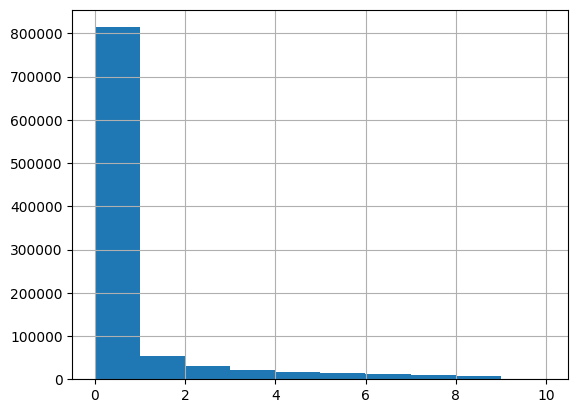

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:05<00:00, 48.31it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7934


event   tolerance
onset   12           0.275481
        36           0.704665
        60           0.793876
        90           0.830553
        120          0.854164
        150          0.862944
        180          0.871999
        240          0.885382
        300          0.890276
        360          0.896683
wakeup  12           0.326584
        36           0.716976
        60           0.801461
        90           0.840804
        120          0.856604
        150          0.869176
        180          0.879450
        240          0.892564
        300          0.904544
        360          0.913195
dtype: float64